# API we will use: Companies House

Companies house is the official public  register of all companies in the UK. You can search for companiers, peope etc. You can also get basic information about many companies, or request detailed information about one company. https://developer.company-information.service.gov.uk/get-started. 

In [1]:
# list of library for this project
import requests
import pprint as pp
import datetime
from datetime import date 
from datetime import datetime
import math
import time
import config
# you might need to add a few of your own

In [10]:
# function for calling the API to retrieve JSON
def call_api_with(url_extension):
    api_key = config.api_key    
    login_headers = {"Authorization":api_key}
    url = f"https://api.companieshouse.gov.uk/{url_extension}"
    #print(f'requesting: {url}') 
    # How many calls you are making
    res = requests.get(url, headers=login_headers) #, verify=False)
    #res.status_code == 200:
    return res.json()
    #else:
        #print("status code is not 'SUCCESS 200'. Will wait 360 seconds/6 minutes")
        #time.sleep(360) # sleep X seconds
        #return call_api_with(url_extension) # then make the same request that brought you here. Basiclaly try again.

In [3]:
def get_one_test_company_or_error():
    url = f"search/companies?q=shop&items_per_page=1"
    return call_api_with(url)

In [4]:
# search company with specific query / keyword
def search_for_companies_with_query(query, number_of_companies = 100):
    # for simplicity round up the number of returned companies to the nearest hundred. eg. 130 becomes 200
    page_size = 100
    number_of_pages = math.ceil(number_of_companies / page_size) # round up
    companies = []
    for page_index in range(0, number_of_pages):
        url = f"search/companies?q={query}&items_per_page={page_size}&start_index={page_index*page_size}"
        companies += call_api_with(url).get('items', [])
    return companies

In [5]:
# request to get company data based on company number
def data_for_company(company_number):
    url = f"company/{company_number}"
    return call_api_with(url)

In [6]:
# get all persons with significant control from company which contains specific keyword
def all_persons_in_company(company_number):
    url = f"company/{company_number}/persons-with-significant-control"
    return call_api_with(url).get('items', [])

In [7]:
def detailed_info_about_companies_with_ids(companies_numbers):
    results = []
    for company_number in companies_numbers:
        results.append(data_for_company(company_number))
    return results

In [8]:
def detailed_info_about_companies_with_name(name, how_many = 10):
    companies_basic_info = search_for_companies_with_query(name, how_many)
    companies_ids = [company['company_number'] for company in companies_basic_info]
    companies = detailed_info_about_companies_with_ids(companies_ids[:how_many])
    return companies

In [11]:
details = detailed_info_about_companies_with_name('banana', how_many=2)

In [15]:
#pp.pprint((details[1]['sic_codes'][0]))
#pp.pprint(len(details))
#pp.pprint([detail for detail in details if detail['sic_codes']==['62020']])
#pp.pprint(details)

In [17]:
#persons = all_persons_in_company(details[1]['company_number'])
#pp.pprint(persons)

## Do companies in stereotypically male dominated fields still showcase the same disparities? Can this present an opportunity for change?

In [199]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import os

In [248]:
def list_of_people_running(companies):
    people =[]
    for i in range(len(companies)):
        person = all_persons_in_company(companies[i]['company_number'])
        people.append(person)
    return people

In [21]:
def get_nature_of_control(list_of_people):
    control = []
    right_per_time =[]
    for person in list_of_people:
        control.append(person['natures_of_control'])
    for person in control:
        for right in person:
            right_per_time.append(right)
    return right_per_time

In [20]:
def count_values(array_of_rights):   
    rights = np.array(array_of_rights)
    frequency_list = pd.value_counts(rights)
    return frequency_list

In [19]:
def get_distribution_of_control(list_of_people):
    nature_of_control_list = get_nature_of_control(list_of_people)
    distribution = count_values(nature_of_control_list)
    return distribution 

In [89]:
def sort_by_age(list_of_company_people):
    twenties_and_under =[]
    thirties = []
    fourties = []
    fifties = []
    over_fifty = []
    for company in list_of_company_people:
        for person in company:
            if 'date_of_birth' in person.keys():
                if 'year' in person['date_of_birth']:
                    year_born = person['date_of_birth']['year']
                    age = 2021 - year_born
                    if age <= 29:     
                        twenties_and_under.append(person)
                    elif age <= 39:
                        thirties.append(person)
                    elif age <=49:
                        fourties.append(person)
                    elif age<=50:
                        fifties.append(person)
                    else:
                        over_fifty.append(person)
    return twenties_and_under,thirties, fourties, fifties, over_fifty

In [41]:
def sort_by_gender(list_of_company_people):
    women=[]
    men = []
    other = []
    for company in list_of_company_people:
        for person in company:
            if 'name_elements' in person.keys():
                if 'title' in person['name_elements']:
                    if (person['name_elements']['title']=='Mrs') or (person['name_elements']['title']=='Mrs ') or (person['name_elements']['title']=='Ms') or (person['name_elements']['title']=='Miss'):
                        women.append(person)
                    elif (person['name_elements']['title']=='Mr') or (person['name_elements']['title']=='Mr.'):
                        men.append(person)
                    else:
                        other.append(person)
    return women,men

In [86]:
def distribution_of_companies(companies_info, by_type):
    company_heads = list_of_people_running(companies_info)
    if by_type == 'gender':
        women,men = sort_by_gender(company_heads)
        return women,men
    elif by_type == 'age':
        twenties_and_under,thirties, fourties, fifties, over_fifties = sort_by_age(company_heads)
        return twenties_and_under,thirties, fourties, fifties, over_fifties

In [168]:
def save_data_as_file(data, file_name):
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)
        
def load_file_named(file_name):
    loaded_data = []
    if os.path.isfile(file_name):
        with open(file_name) as infile:
            loaded_data =  json.load(infile)
    return loaded_data
    
def add_data_to_file(data_list, file_name):
    data = load_file_named(file_name)
    data.extend(data_list)
    save_data_as_file( data,file_name)

#### Retrieve companies related to tech, recreation, health, education, real estate, and accounting.

In [167]:
tech_com = detailed_info_about_companies_with_name('technology', how_many=500)

In [26]:
real_estate_com = detailed_info_about_companies_with_name('real estate', how_many=500)

In [27]:
accounting_com = detailed_info_about_companies_with_name('accounting', how_many=500)

In [28]:
education_com = detailed_info_about_companies_with_name('education', how_many=500)

Create .json file to save data and add data to api_data.json:

In [84]:
file_name = "api_data.json"
data = load_file_named(file_name)

In [71]:
#add_data_to_file([tech_com], file_name)
#add_data_to_file([real_estate_com], file_name)
#add_data_to_file([accounting_com], file_name)
#add_data_to_file([education_com], file_name)

Get company heads and split them by gender.

*If running code by calling data from .json run the cell below:*

In [72]:
#data = load_file_named(file_name)
#tech_com = data[0]
#real_estate_com = data[1]
#accounting_com = data[2]
#education_com = data[3]

In [45]:
tech_women, tech_men = distribution_of_companies(tech_com, 'gender')

In [56]:
real_estate_women, real_estate_men = distribution_of_companies(real_estate_com, 'gender')

In [65]:
accounting_women, accounting_men = distribution_of_companies(accounting_com, 'gender')

In [76]:
education_women, education_men = distribution_of_companies(education_com, 'gender')

Save data to .json file

In [77]:
#add_data_to_file([tech_women], file_name)
#add_data_to_file([tech_men], file_name)
#add_data_to_file([real_estate_women], file_name)
#add_data_to_file([real_estate_men], file_name)
#add_data_to_file([accounting_women], file_name)
#add_data_to_file([accounting_men], file_name)
#add_data_to_file([education_women], file_name)
#add_data_to_file([education_men], file_name)

#### Get company heads and split by age.

In [90]:
tech_age_twenties_and_under,tech_age_thirties, tech_age_fourties, tech_age_fifties, tech_age_over_fifties = distribution_of_companies(tech_com, 'age')

In [94]:
real_estate_age_twenties_and_under,real_estate_age_thirties, real_estate_age_fourties, real_estate_age_fifties, real_estate_age_over_fifties = distribution_of_companies(real_estate_com, 'age')

In [97]:
accounting_age_twenties_and_under,accounting_age_thirties, accounting_age_fourties, accounting_age_fifties, accounting_age_over_fifties = distribution_of_companies(accounting_com, 'age')

In [100]:
education_age_twenties_and_under,education_age_thirties, education_age_fourties, education_age_fifties, education_age_over_fifties = distribution_of_companies(education_com, 'age')

Save data to .json file

In [101]:
#tech by age
#add_data_to_file([tech_age_twenties_and_under], file_name)
#add_data_to_file([tech_age_thirties], file_name)
#add_data_to_file([tech_age_fourties], file_name)
#add_data_to_file([tech_age_fifties], file_name)
#add_data_to_file([tech_age_over_fifties], file_name)
#real estate by age
#add_data_to_file([real_estate_age_twenties_and_under], file_name)
#add_data_to_file([real_estate_age_thirties], file_name)
#add_data_to_file([real_estate_age_fourties], file_name)
#add_data_to_file([real_estate_age_fifties], file_name)
#add_data_to_file([real_estate_age_over_fifties], file_name)
#accounting by age
#add_data_to_file([accounting_age_twenties_and_under], file_name)
#add_data_to_file([accounting_age_thirties], file_name)
#add_data_to_file([accounting_age_fourties], file_name)
#add_data_to_file([accounting_age_fifties], file_name)
#add_data_to_file([accounting_age_over_fifties], file_name)
#education by age
#add_data_to_file([education_age_twenties_and_under], file_name)
#add_data_to_file([education_age_thirties], file_name)
#add_data_to_file([education_age_fourties], file_name)
#add_data_to_file([education_age_fifties], file_name)
#add_data_to_file([education_age_over_fifties], file_name)

#### Get distribution of positions by gender.

*If running from .json file run the cell below to get data:*

In [78]:
#file_name = "api_data.json"
#data = load_file_named(file_name)
#tech_women = data[4]
#tech_men = data[5]
#real_estate_women = data[6]
#real_estate_men = data[7]
#accounting_women = data[8]
#accounting_men = data[9]
#education_women = data[10]
#education_men = data[11]

In [107]:
tech_men_distribution = get_distribution_of_control(tech_men)
tech_women_distribution = get_distribution_of_control(tech_women)

In [108]:
real_estate_men_distribution = get_distribution_of_control(real_estate_men)
real_estate_women_distribution = get_distribution_of_control(real_estate_women)

In [109]:
accounting_men_distribution = get_distribution_of_control(accounting_men)
accounting_women_distribution = get_distribution_of_control(accounting_women)

In [110]:
education_men_distribution = get_distribution_of_control(education_men)
education_women_distribution = get_distribution_of_control(education_women)

#### Get distribution of positions by age.

*If running from .json file run the cell below to get data:*

In [102]:
#file_name = "api_data.json"
#data = load_file_named(file_name)
#tech_age_twenties_and_under = data[12]
#tech_age_thirties= data[13]
#tech_age_fourties= data[14]
#tech_age_fifties= data[15]
#tech_age_over_fifties= data[16]
#real_estate_age_twenties_and_under= data[17]
#real_estate_age_thirties= data[18]
#real_estate_age_fourties= data[19]
#real_estate_age_fifties= data[20]
#real_estate_age_over_fifties= data[21]
#accounting_age_twenties_and_under= data[22]
#accounting_age_thirties= data[23]
#accounting_age_fourties= data[24]
#accounting_age_fifties= data[25]
#accounting_age_over_fifties= data[26]
#education_age_twenties_and_under= data[27]
#education_age_thirties= data[28]
#education_age_fourties= data[29]
#education_age_fifties= data[29]
#education_age_over_fifties= data[30]

In [111]:
tech_twenties_and_under_distribution = get_distribution_of_control(tech_age_twenties_and_under)
tech_thirties_distribution = get_distribution_of_control(tech_age_thirties)
tech_fourties_distribution = get_distribution_of_control(tech_age_fourties)
tech_fifties_distribution = get_distribution_of_control(tech_age_fifties)
tech_over_fifties_distribution = get_distribution_of_control(tech_age_over_fifties)

In [112]:
real_estate_twenties_and_under_distribution = get_distribution_of_control(real_estate_age_twenties_and_under)
real_estate_thirties_distribution = get_distribution_of_control(real_estate_age_thirties)
real_estate_fourties_distribution = get_distribution_of_control(real_estate_age_fourties)
real_estate_fifties_distribution = get_distribution_of_control(real_estate_age_fifties)
real_estate_over_fifties_distribution = get_distribution_of_control(real_estate_age_over_fifties)

In [113]:
accounting_twenties_and_under_distribution = get_distribution_of_control(accounting_age_twenties_and_under)
accounting_thirties_distribution = get_distribution_of_control(accounting_age_thirties)
accounting_fourties_distribution = get_distribution_of_control(accounting_age_fourties)
accounting_fifties_distribution = get_distribution_of_control(accounting_age_fifties)
accounting_over_fifties_distribution = get_distribution_of_control(accounting_age_over_fifties)

In [114]:
education_twenties_and_under_distribution = get_distribution_of_control(education_age_twenties_and_under)
education_thirties_distribution = get_distribution_of_control(education_age_thirties)
education_fourties_distribution = get_distribution_of_control(education_age_fourties)
education_fifties_distribution = get_distribution_of_control(education_age_fifties)
education_over_fifties_distribution = get_distribution_of_control(education_age_over_fifties)

Find top positions held by women and add men in tech and create a dataframe to plot bar graph.

In [119]:
tech_women_distribution[:5]

ownership-of-shares-25-to-50-percent     55
right-to-appoint-and-remove-directors    38
voting-rights-25-to-50-percent           36
ownership-of-shares-75-to-100-percent    28
voting-rights-75-to-100-percent          20
dtype: int64

In [250]:
tech_men_distribution[:5]

ownership-of-shares-75-to-100-percent    212
right-to-appoint-and-remove-directors    151
voting-rights-75-to-100-percent          136
ownership-of-shares-25-to-50-percent      93
voting-rights-25-to-50-percent            50
dtype: int64

### Graph for men vs. women in tech

In [123]:
tech_men_v_women = pd.DataFrame({
    "Men":[212, 151, 136, 93],
    "Women":[28, 38, 20, 55],
    }, 
    index=["Ownership of 75-100%", "Appoint and remove directors", "Voting rights 75-100%", "Ownership of shares 25-50%"]
)

Text(0, 0.5, 'Number of people')

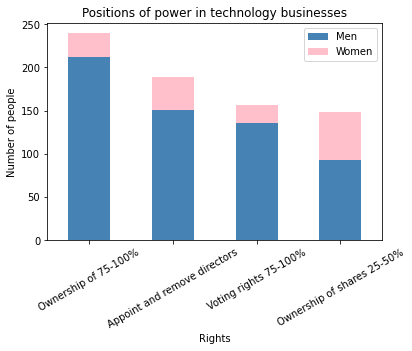

In [200]:
tech_men_v_women.plot(kind='bar', stacked=True, color=['steelblue','pink'])
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Positions of power in technology businesses")
plt.xlabel("Rights")
plt.ylabel("Number of people")

Control in technology businesses by age:

In [243]:
print("People in their 20's and under")
print(tech_twenties_and_under_distribution[:3])
print("People in their 30's")
print(tech_thirties_distribution[:3])
print("People in their 40's")
print(tech_fourties_distribution[:3])
print("People in their 50's")
print(tech_fifties_distribution[:3])
print("People over 50")
print(tech_over_fifties_distribution[:3])

People in their 20's and under
ownership-of-shares-75-to-100-percent    20
voting-rights-75-to-100-percent          20
right-to-appoint-and-remove-directors    19
dtype: int64
People in their 30's
ownership-of-shares-75-to-100-percent    51
right-to-appoint-and-remove-directors    43
voting-rights-75-to-100-percent          34
dtype: int64
People in their 40's
ownership-of-shares-75-to-100-percent    65
right-to-appoint-and-remove-directors    57
ownership-of-shares-25-to-50-percent     47
dtype: int64
People in their 50's
ownership-of-shares-75-to-100-percent    14
voting-rights-75-to-100-percent          10
right-to-appoint-and-remove-directors     9
dtype: int64
People over 50
ownership-of-shares-75-to-100-percent    120
right-to-appoint-and-remove-directors     91
ownership-of-shares-25-to-50-percent      90
dtype: int64


Find top positions held by women and add men in real estate and create a dataframe to plot bar graph.

In [137]:
real_estate_women_distribution[:5]

ownership-of-shares-75-to-100-percent    37
right-to-appoint-and-remove-directors    29
ownership-of-shares-25-to-50-percent     28
voting-rights-75-to-100-percent          24
voting-rights-25-to-50-percent           18
dtype: int64

In [245]:
real_estate_men_distribution[:5]

ownership-of-shares-75-to-100-percent    171
right-to-appoint-and-remove-directors    130
voting-rights-75-to-100-percent          110
ownership-of-shares-25-to-50-percent     108
voting-rights-25-to-50-percent            73
dtype: int64

### Graph for men vs. women in real_estate

In [139]:
real_estate_men_v_women = pd.DataFrame({
    "Men":[171, 130, 110,108],
    "Women":[37, 29, 24, 28],
    }, 
    index=["Ownership of 75-100%", "Appoint and remove directors", "Voting rights 75-100%", "Ownership of shares 25-50%"]
)

Text(0, 0.5, 'Number of people')

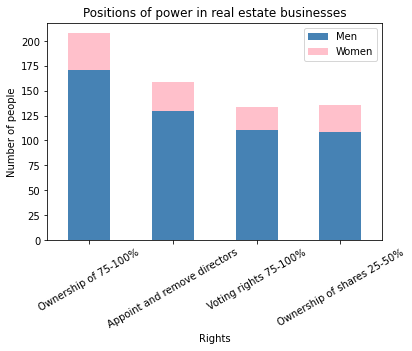

In [205]:
real_estate_men_v_women.plot(kind='bar', stacked=True,color=['steelblue','pink'])
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Positions of power in real estate businesses")
plt.xlabel("Rights")
plt.ylabel("Number of people")

Control in real estate businesses by age:

In [242]:
print("People in their 20's and under")
print(real_estate_twenties_and_under_distribution[:3])
print("People in their 30's")
print(real_estate_thirties_distribution[:3])
print("People in their 40's")
print(real_estate_fourties_distribution[:3])
print("People in their 50's")
print(real_estate_fifties_distribution[:3])
print("People over 50")
print(real_estate_over_fifties_distribution[:3])

People in their 20's and under
ownership-of-shares-75-to-100-percent    18
right-to-appoint-and-remove-directors    17
ownership-of-shares-25-to-50-percent     13
dtype: int64
People in their 30's
ownership-of-shares-75-to-100-percent    47
right-to-appoint-and-remove-directors    37
voting-rights-75-to-100-percent          35
dtype: int64
People in their 40's
ownership-of-shares-75-to-100-percent    57
right-to-appoint-and-remove-directors    53
ownership-of-shares-25-to-50-percent     45
dtype: int64
People in their 50's
ownership-of-shares-75-to-100-percent    9
voting-rights-75-to-100-percent          5
right-to-appoint-and-remove-directors    4
dtype: int64
People over 50
ownership-of-shares-75-to-100-percent    97
ownership-of-shares-25-to-50-percent     62
voting-rights-75-to-100-percent          58
dtype: int64


Find top positions held by women and add men in accounting and create a dataframe to plot bar graph.

In [144]:
accounting_women_distribution[:5]

ownership-of-shares-75-to-100-percent    130
right-to-appoint-and-remove-directors     67
voting-rights-75-to-100-percent           67
ownership-of-shares-25-to-50-percent      59
voting-rights-25-to-50-percent            36
dtype: int64

In [244]:
accounting_men_distribution[:5]

ownership-of-shares-75-to-100-percent    202
right-to-appoint-and-remove-directors    108
voting-rights-75-to-100-percent          107
ownership-of-shares-25-to-50-percent      85
voting-rights-25-to-50-percent            43
dtype: int64

### Graph for men v. women in accounting

In [146]:
accounting_men_v_women = pd.DataFrame({
    "Men":[202, 108, 107,85],
    "Women":[130, 67, 67, 59],
    }, 
    index=["Ownership of 75-100%", "Appoint and remove directors", "Voting rights 75-100%", "Ownership of shares 25-50%"]
)

Text(0, 0.5, 'Number of people')

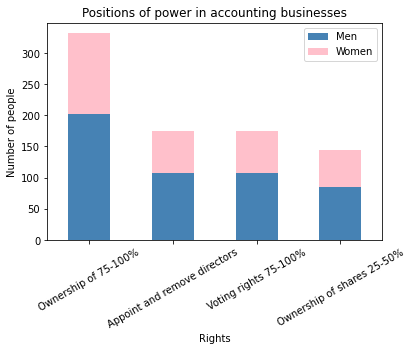

In [203]:
accounting_men_v_women.plot(kind='bar', stacked=True, color=['steelblue','pink'])
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Positions of power in accounting businesses")
plt.xlabel("Rights")
plt.ylabel("Number of people")

In [241]:
print("People in their 20's and under")
print(accounting_twenties_and_under_distribution[:3])
print("People in their 30's")
print(accounting_thirties_distribution[:3])
print("People in their 40's")
print(accounting_fourties_distribution[:3])
print("People in their 50's")
print(accounting_fifties_distribution[:3])
print("People over 50")
print(accounting_over_fifties_distribution[:3])

People in their 20's and under
ownership-of-shares-75-to-100-percent    19
voting-rights-75-to-100-percent          16
right-to-appoint-and-remove-directors    16
dtype: int64
People in their 30's
ownership-of-shares-75-to-100-percent    58
right-to-appoint-and-remove-directors    33
voting-rights-75-to-100-percent          32
dtype: int64
People in their 40's
ownership-of-shares-75-to-100-percent    91
right-to-appoint-and-remove-directors    48
voting-rights-75-to-100-percent          46
dtype: int64
People in their 50's
ownership-of-shares-75-to-100-percent    13
voting-rights-75-to-100-percent           6
ownership-of-shares-25-to-50-percent      6
dtype: int64
People over 50
ownership-of-shares-75-to-100-percent    165
right-to-appoint-and-remove-directors     82
voting-rights-75-to-100-percent           82
dtype: int64


Find top positions held by women and add men in education and create a dataframe to plot bar graph.

In [149]:
education_women_distribution[:5]

ownership-of-shares-75-to-100-percent    83
right-to-appoint-and-remove-directors    72
voting-rights-75-to-100-percent          58
ownership-of-shares-25-to-50-percent     55
voting-rights-25-to-50-percent           49
dtype: int64

In [246]:
education_men_distribution[:5]

ownership-of-shares-75-to-100-percent    146
right-to-appoint-and-remove-directors    125
ownership-of-shares-25-to-50-percent      91
voting-rights-75-to-100-percent           87
voting-rights-25-to-50-percent            76
dtype: int64

### Graph for men vs. women in education

In [151]:
education_men_v_women = pd.DataFrame({
    "Men":[146, 125, 87, 91],
    "Women":[83, 72,58, 55],
    }, 
     index=["Ownership of 75-100%", "Appoint and remove directors", "Voting rights 75-100%", "Ownership of shares 25-50%"]
)

Text(0, 0.5, 'Number of people')

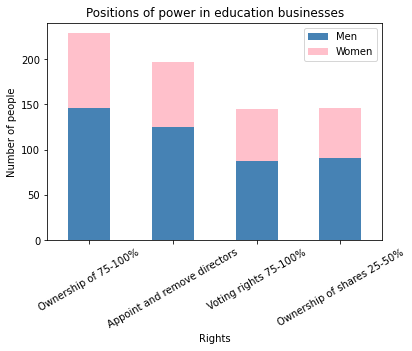

In [204]:
education_men_v_women.plot(kind='bar', stacked=True, color=['steelblue','pink'])
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Positions of power in education businesses")
plt.xlabel("Rights")
plt.ylabel("Number of people")

In [253]:
print("People in their 20's and under")
print(education_twenties_and_under_distribution[:3])
print("People in their 30's")
print(education_thirties_distribution[:3])
print("People in their 40's")
print(education_fourties_distribution[:3])
print("People in their 50's")
print(education_fifties_distribution[:3])
print("People over 50")
print(education_over_fifties_distribution[:3])

People in their 20's and under
right-to-appoint-and-remove-directors    18
ownership-of-shares-75-to-100-percent    15
voting-rights-75-to-100-percent          11
dtype: int64
People in their 30's
ownership-of-shares-75-to-100-percent    58
right-to-appoint-and-remove-directors    57
voting-rights-75-to-100-percent          45
dtype: int64
People in their 40's
ownership-of-shares-75-to-100-percent    74
right-to-appoint-and-remove-directors    60
voting-rights-75-to-100-percent          49
dtype: int64
People in their 50's
ownership-of-shares-75-to-100-percent    74
right-to-appoint-and-remove-directors    60
voting-rights-75-to-100-percent          49
dtype: int64
People over 50
right-to-appoint-and-remove-directors    7
ownership-of-shares-75-to-100-percent    6
voting-rights-75-to-100-percent          4
dtype: int64


Text(0, 0.5, 'Number of people')

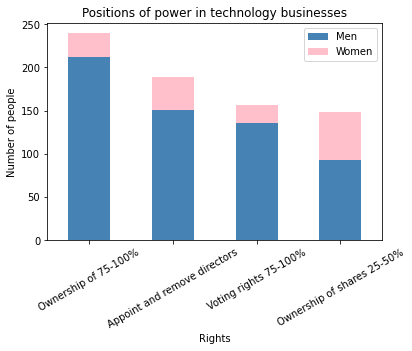

In [236]:
tech_men_v_women.plot(kind='bar', stacked=True, color=['steelblue','pink'])
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Positions of power in technology businesses")
plt.xlabel("Rights")
plt.ylabel("Number of people")

## When's a good time to start a tourism business?

In [272]:
def check_sic_codes(company_list):
    sic_codes = []
    i = 0
    for set_of_companies in company_list:
        for company in set_of_companies:
            if 'sic_codes' in company.keys():
                for code in company['sic_codes']:
                    sic_codes.append(company['sic_codes'][i])
                else:
                    i = 0
    frequency = count_values(sic_codes)
    return frequency

def actual_registered_travel_comp(list_of_companies):
    list_of_cos = []
    for companies in list_of_companies:
        for company in companies:
            if 'sic_codes' in company.keys():
                for code in company['sic_codes']:
                    if company not in list_of_cos: 
                        if (code == '79110') or (code == '79120')  or (code == '79901') or (code == '55100') or (code == '55201') or (code == '55209') or (code == '55202'):
                            list_of_cos.append(company)
    return list_of_cos

def active_companies(companies):
    active_company = []
    for company in companies:
        if company['company_status'] == "active":
            active_company.append(company)
    return active_company

def dead_companies(companies):
    dead_companies = []
    for company in companies:
        if company['company_status'] == "dissolved":
            dead_companies.append(company)
    return dead_companies

def get_companies_avg_age(companies):
    total_ages = 0
    counter = 0
    for company in companies:
        if ('date_of_creation' in company.keys() and (pd.isna(company['date_of_creation'])==False)):
            creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
            company_age = datetime.now() - creation_date
            company_age = company_age.days
            if company_age>1:
                total_ages += int(company_age)
                counter += 1
    avg_age = (total_ages/counter)/365
    return avg_age

def get_dead_companies_avg_age(companies):
    total_ages = 0
    counter = 0
    for company in companies:
        if ('date_of_creation' in company.keys() and (pd.isna(company['date_of_creation'])==False)):
            creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
            cessation_date = pd.to_datetime(company['date_of_cessation'],infer_datetime_format=True)
            company_life = cessation_date - creation_date
            company_length = company_life.days
            if company_length>1:
                total_ages += int(company_length)
                counter += 1
    avg_age = (total_ages/counter)/365
    return avg_age

def companies_older_avg(companies, avg_age):
    older_than_avg=[]
    for company in companies:
        if ('date_of_creation' in company.keys()):
            creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
            company_age = datetime.now() - creation_date
            company_age = (company_age.days)/365
        if avg_age <=company_age:
            older_than_avg.append(company)
    return older_than_avg

def month_of_creation_or_cessation(companies,create_or_dead):
    time_period = []
    if create_or_dead == 'creation':
        for company in companies:
            if ('date_of_creation' in company.keys() and (pd.isna(company['date_of_creation'])==False)):
                creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
                creation_time = creation_date.month
                if creation_time>0:
                    time_period.append(creation_time)
        return time_period
    else:
        for company in companies:
            if ('date_of_cessation' in company.keys() and (pd.isna(company['date_of_cessation'])==False)):
                cessation_date = pd.to_datetime(company['date_of_cessation'],infer_datetime_format=True)
                cessation_time = cessation_date.month
                if cessation_time>0:
                    time_period.append(cessation_time)
        return time_period
    
def year_of_creation_or_cessation(companies,create_or_dead):
    time_period = []
    if create_or_dead == 'creation':
        for company in companies:
            if ('date_of_creation' in company.keys() and (pd.isna(company['date_of_creation'])==False)):
                creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
                creation_time = creation_date.year
                if creation_time>0:
                    time_period.append(creation_time)
        return time_period
    else:
        for company in companies:
            if ('date_of_cessation' in company.keys() and (pd.isna(company['date_of_cessation'])==False)):
                cessation_date = pd.to_datetime(company['date_of_cessation'],infer_datetime_format=True)
                cessation_time = cessation_date.year
                if cessation_time>0:
                    time_period.append(cessation_time)
        return time_period
    
def cities_of_comp(companies):
    cities = []
    for company in companies:
        if 'locality' in company['registered_office_address'].keys():
            cities.append(company['registered_office_address']['locality'])
    return cities

Get data on companies from tourism industry

In [249]:
travel_companies = detailed_info_about_companies_with_name('travel', 500)

In [255]:
trip_companies = detailed_info_about_companies_with_name('trip', 500)

In [258]:
cruise_companies = detailed_info_about_companies_with_name('cruise', 500)

In [260]:
bnb_companies = detailed_info_about_companies_with_name('B&B', 500)

In [265]:
souvenir_companies = detailed_info_about_companies_with_name('souvenir', 500)

Save data on .json file:

In [266]:
#file_name = "api_data_2.json"
#data = load_file_named(file_name)

#add_data_to_file([travel_companies], file_name)
#add_data_to_file([trip_companies], file_name)
#add_data_to_file([cruise_companies], file_name)
#add_data_to_file([bnb_companies], file_name)
#add_data_to_file([souvenir_companies], file_name)

*If running from .json file, run cell below to fetch data:*

In [ ]:
#file_name = "api_data_2.json"
#data = load_file_named(file_name)
#travel_companies = data[0]
#trip_companies = data[1]
#cruise_companies = data[2]
#bnb_companies = data[3]
#souvenir_companies = data[4]

Check most frequent SIC codes and cross-check with SIC database for businesses pertaining to tourism industry

In [270]:
potential_companies = [travel_companies,trip_companies,cruise_companies,bnb_companies,souvenir_companies]

In [275]:
most_common_sic_codes = check_sic_codes(potential_companies)
pp.pprint(most_common_sic_codes[:10])

79110    409
79120     87
82990     78
47190     77
99999     76
50100     65
49320     64
96090     59
47910     54
70229     52
dtype: int64


Filter all companies found and only keep those who have one of 7 codes pertaining to tourism industry.

In [276]:
registered_travel_comp = actual_registered_travel_comp(potential_companies)

Separate active and dead/failed tourism companies.

In [278]:
active_registered_travel_companies = active_companies(registered_travel_comp)

In [279]:
dead_travel_companies = dead_companies(registered_travel_comp)

Get average age of active companies and average lifespan of failed companies.

In [280]:
avg_age_active_companies = get_companies_avg_age(active_registered_travel_companies)
avg_age_active_companies

6.949056670560335

In [281]:
avg_age_dead_companies = get_dead_companies_avg_age(dead_travel_companies)
avg_age_dead_companies

4.207023265927376

Retrieve companies that are above the average age and find their average age.

In [282]:
old_travel_comp = companies_older_avg(active_registered_travel_companies, avg_age_active_companies)
old_travel_avg_age = get_companies_avg_age(old_travel_comp)
old_travel_avg_age

16.581765857027744

Find the month that most companies were created and the months that most companies seized to exist.

In [283]:
active_month_of_creation = month_of_creation_or_cessation(active_registered_travel_companies, 'creation')
old_travel_comp_creation = month_of_creation_or_cessation(old_travel_comp, 'creation')
month_of_cessation = month_of_creation_or_cessation(dead_travel_companies, 'a')

In [284]:
print('Frequency of month of creation for older than average tourism companies.')
print(pd.value_counts(old_travel_comp_creation))

Frequency of month of creation for older than average tourism companies.
7     17
4     15
5     12
8     11
2     10
12    10
9     10
10     9
3      8
11     8
6      5
1      4
dtype: int64


In [299]:
old_x = [1,2,3,4,5,6,7,8,9,10,11,12]
old_y = [4,10,8,15,12,5,17,11,10,9,8,10]

In [285]:
print('Frequency of month of creation for all active tourism companies.')
print(pd.value_counts(active_month_of_creation))

Frequency of month of creation for all active tourism companies.
4     43
7     39
2     38
11    33
8     33
9     32
3     30
10    29
6     29
12    28
1     27
5     26
dtype: int64


In [286]:
print('Frequency of month of cessation for all failed tourism companies.')
print(pd.value_counts(month_of_cessation))

Frequency of month of cessation for all failed tourism companies.
9     18
3     17
10    16
4     11
1     10
7     10
8     10
5      9
12     9
6      9
11     4
2      3
dtype: int64


In [300]:
cess_x = [1,2,3,4,5,6,7,8,9,10,11,12]
cess_y = [10,3,17,11,9,9,10,10,18,16,4,9]

Get year of creation and cessation for all three groups of companies and investigate frequency.

In [287]:
old_travel_comp_creation = year_of_creation_or_cessation(old_travel_comp, 'creation')
active_travel_comp_creation = year_of_creation_or_cessation(active_registered_travel_companies, 'creation')
dead_travel_comp_founding =year_of_creation_or_cessation(dead_travel_companies, '')

In [336]:
print('Frequency of years of creation for all active tourism companies.')
print(pd.value_counts(active_travel_comp_creation[:5]))

Frequency of years of creation for all active tourism companies.
2019    1
2006    1
2020    1
2021    1
2017    1
dtype: int64


In [335]:
print('Frequency of years of creation for older than average tourism companies.')
print(pd.value_counts(old_travel_comp_creation[:5]))

Frequency of years of creation for older than average tourism companies.
2011    2
2006    1
2002    1
2005    1
dtype: int64


In [290]:
print('Frequency of years of cessation for all dead tourism companies.')
print(pd.value_counts(dead_travel_comp_founding))

Frequency of years of cessation for all dead tourism companies.
2021    66
2019    19
2020    12
2018     9
2017     5
2013     5
2014     4
2015     3
2016     3
dtype: int64


Get cities where most of the active, dead, and older tourism companies are.

In [291]:
dead_travel_cities = cities_of_comp(dead_travel_companies)
old_travel_cities = cities_of_comp(old_travel_comp)
active_travel_cities = cities_of_comp(active_registered_travel_companies)

In [585]:
pd.value_counts(old_travel_cities)[:10]

London        32
Redditch       3
Manchester     3
Leicester      2
Brighton       2
Isleworth      2
Birmingham     2
Tring          2
Colchester     2
Cheltenham     2
dtype: int64

In [583]:
pd.value_counts(active_travel_cities)[:10]

London        125
Leicester       8
Manchester      6
Glasgow         6
Preston         5
Nottingham      4
Isleworth       4
Grimsby         4
Birmingham      4
Bedford         3
dtype: int64

In [294]:
pd.value_counts(dead_travel_cities)[:5]

London        40
Portsmouth     3
Ilford         3
Solihull       3
Birmingham     3
dtype: int64

In [295]:
pd.value_counts(month_of_cessation)[:5]

9     18
3     17
10    16
4     11
1     10
dtype: int64

In [333]:
pd.value_counts(old_travel_comp_creation)[:20]

2011    12
2012    11
2010    10
2014     9
2004     8
2006     8
2013     7
2008     6
2005     6
2007     5
2002     5
2009     5
1996     4
2003     4
1993     2
1995     2
1994     2
1987     2
1989     2
1969     1
dtype: int64

In [307]:
year_old_x = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014]
year_old_y = [8,6,8,5,6,5,10,12,11,7,9]

Graph experience businesses vs. failed businesses months of inception and creation

Text(0, 0.5, 'Number of businesses')

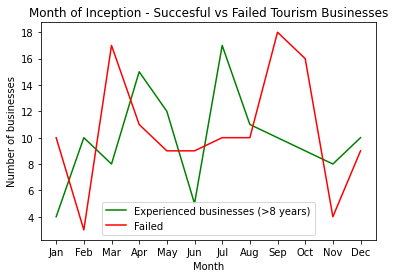

In [301]:
plt.plot(old_x, old_y, label = "Experienced businesses (>8 years)", color='g')

# plot lines
plt.plot(cess_x, cess_y, label = "Failed", color='r')
plt.legend()
plt.title("Month of Inception - Succesful vs Failed Tourism Businesses")
plt.xlabel("Month")
plt.xticks(old_x, ['Jan', 'Feb', 'Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel("Number of businesses")

Text(0, 0.5, 'Number of businesses')

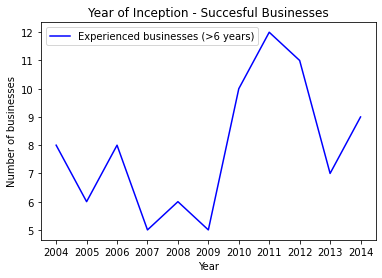

In [311]:
plt.plot(year_old_x, year_old_y, label = "Experienced businesses (>6 years)", color='blue')
plt.legend()
plt.title("Year of Inception - Succesful Businesses")
plt.xlabel("Year")
plt.xticks(year_old_x)
plt.ylabel("Number of businesses")

Text(0, 0.5, 'Number of businesses')

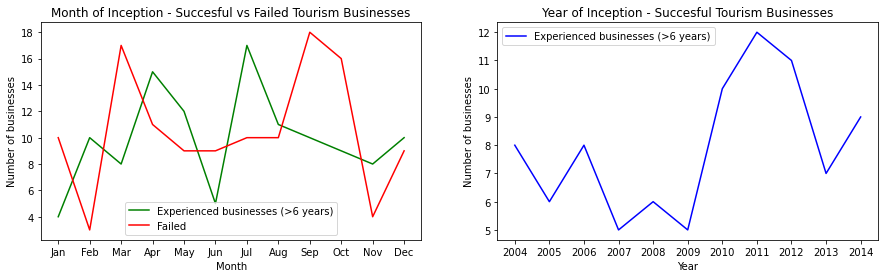

In [334]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(old_x, old_y, label = "Experienced businesses (>6 years)", color='g')
# plot lines
plt.plot(cess_x, cess_y, label = "Failed", color='r')
plt.legend()
plt.title("Month of Inception - Succesful vs Failed Tourism Businesses")
plt.xlabel("Month")
plt.xticks(old_x, ['Jan', 'Feb', 'Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel("Number of businesses")

plt.subplot(1,2,2)
plt.plot(year_old_x, year_old_y, label = "Experienced businesses (>6 years)", color='blue')
plt.legend()
plt.title("Year of Inception - Succesful Tourism Businesses")
plt.xlabel("Year")
plt.xticks(year_old_x)
plt.ylabel("Number of businesses")

## What is the best place in UK to set up a fintech company? 

Helper functions:

In [337]:
def get_distribution(list_of_items):
    distribution = count_values(list_of_items)
    return distribution 

In [580]:
import collections
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from numpy import asarray

def filter_fintech_comp(list_of_companies):
    list_of_cos = []
    for companies in list_of_companies:
        for company in companies:
            if 'sic_codes' in company.keys():
                for code in company['sic_codes']:
                    if company not in list_of_cos: 
                        if (code == '62020') or (code == '62012')  or (code == '64999') or (code == '62090') or (code == '82990') or (code == '70229') or (code == '64929'):
                            list_of_cos.append(company)
    return list_of_cos

def store_by_year_creation(list_of_companies):
    fintech_2018=[]
    fintech_2019=[]
    fintech_2020=[]
    fintech_2021=[]
    fintech = []
    for company in list_of_companies:
        creation_date = pd.to_datetime(company['date_of_creation'],infer_datetime_format=True)
        creation_time = creation_date.year
        if creation_time == 2018:
            fintech_2018.append(company)
        elif creation_time == 2019:
            fintech_2019.append(company)
        elif creation_time == 2020:
            fintech_2020.append(company)
        elif creation_time == 2021:
            fintech_2021.append(company)
        else:
            fintech.append(company)
    return fintech_2018, fintech_2019, fintech_2020, fintech_2021, fintech

def frequency_of_cities(position_list):
    counter = collections.Counter(position_list)
    return counter

def get_word_cloud(frequencies):
    medical_icon_mask_image = np.array(Image.open("uk_map.png"))
    colors = ["#6D37F5", '#57BFB5', '#ECB0C1', '#EB675F']
    #Colours of Monzo bank, starling bank, moneybox, and Klarna
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    wordcloud = WordCloud(width=1000, height=1600, background_color="white", mask=medical_icon_mask_image, colormap=cmap)
    wordcloud.generate_from_frequencies(frequencies)
    plt.figure(figsize=(10,14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Cities of fintech businesses founded before 2018 ", fontsize = 'larger', fontweight = 'bold', verticalalignment = 'center')
    plt.axis("off")

In [338]:
fintech_companies = detailed_info_about_companies_with_name('fintech', 500)

In [342]:
crypto_companies = detailed_info_about_companies_with_name('crypto', 500)

In [344]:
financial_tech_companies = detailed_info_about_companies_with_name('financial technology', 500)

In [346]:
lending_companies = detailed_info_about_companies_with_name('digital lending ', 500)

Save to .json file:

In [347]:
#file_name = "api_data_3.json"
#data = load_file_named(file_name)

#add_data_to_file([fintech_companies], file_name)
#add_data_to_file([crypto_companies], file_name)
#add_data_to_file([financial_tech_companies], file_name)
#add_data_to_file([lending_companies], file_name)

Check most common SIC codes:

*If running from .json file run the cell below:*

In [341]:
#file_name = "api_data_3.json"
#data = load_file_named(file_name)
#fintech_companies = data[0]
#crypto_companies = data[1]
#financial_tech_companies = data[2]
#lending_companies = data[3]

In [348]:
potential_fintech_companies = [fintech_companies,crypto_companies,financial_tech_companies, lending_companies]

In [349]:
most_common_fintech_sic = check_sic_codes(potential_fintech_companies)

In [350]:
pp.pprint(most_common_fintech_sic[:10])

62020    334
62012    199
64999    167
62090    140
82990    110
70229     81
64929     73
66300     73
64205     73
70221     71
dtype: int64


Filter fintech companies based on their SIC codes.

In [353]:
true_fintech = filter_fintech_comp(potential_fintech_companies)

Sort fintech companies by year of creation.

In [354]:
fintech_2018, fintech_2019, fintech_2020, fintech_2021, fintech_older = store_by_year_creation(true_fintech)

Get cities where most fintech companies were created by year and find those that are most frequent. 

In [355]:
cities_fintech_2018 = cities_of_comp(fintech_2018)
cities_fintech_2019 = cities_of_comp(fintech_2019)
cities_fintech_2020 = cities_of_comp(fintech_2020)
cities_fintech_2021 = cities_of_comp(fintech_2021)
cities_fintech_older = cities_of_comp(fintech_older)

In [556]:
pd.value_counts(cities_fintech_2018)

London                    45
Reading                    3
Stockport                  3
Harrow                     3
Cardiff                    3
Manchester                 2
Leeds                      1
Ashford                    1
Camberley                  1
Woodford Green             1
Aylesbury                  1
Rossendale                 1
Seamer                     1
Staines-Upon-Thames        1
Glasgow                    1
Meridian Business Park     1
Hornchurch                 1
Wokingham                  1
Sutton                     1
Hemel Hempstead            1
Waterlooville              1
Stroud                     1
Leicester                  1
Edinburgh                  1
Harpenden                  1
Worthing                   1
Lisburn                    1
Slough                     1
Bath                       1
Cambridge                  1
Knutsford                  1
Bromley                    1
Ilford                     1
Newport Pagnell            1
Derby         

In [557]:
pd.value_counts(cities_fintech_2019)

London                  47
Bath                     5
Cardiff                  3
Altrincham               2
Croydon                  2
Manchester               2
Co Durham                1
Atherstone               1
Ellesmere Port           1
Royston                  1
Leicester                1
Exeter                   1
Cannock                  1
Harrow                   1
Marlow                   1
Sevenoaks                1
Weybridge                1
West Linton              1
Haywards Heath           1
Dartfod                  1
Norwich                  1
Cheadle                  1
Stockport                1
Edinburgh                1
Cirencester              1
Peterlee                 1
Newbury                  1
Putney                   1
North Shields            1
Bromley                  1
Belfast                  1
Romford                  1
Sutton                   1
Buckingham               1
Brighton                 1
Southall                 1
Bedford                  1
W

In [558]:
pd.value_counts(cities_fintech_2020)

London                    66
Bath                       4
London,                    2
Leicester                  2
Brighton                   2
Hounslow                   2
Romford                    1
Salford                    1
Kettering                  1
Stockport                  1
Slough                     1
Manchester                 1
Horsham                    1
Bedford                    1
Cambridge                  1
Solihull                   1
Dudley                     1
Altrincham                 1
Fleet                      1
Birmingham                 1
Blackburn                  1
Launceston                 1
Southend-On-Sea            1
Crawley                    1
Cardiff                    1
England, London            1
Stratford                  1
Cheltenham                 1
Chesham                    1
Finchley                   1
Ashton Under Lyne          1
Camberley                  1
Edinburgh                  1
Glasgow                    1
Warrington    

In [559]:
pd.value_counts(cities_fintech_2021)

London                  85
Cardiff                  3
Worcester Park           3
Manchester               3
Northwood                2
                        ..
Burry Port               1
Goole                    1
Bollington               1
Kingston Upon Thames     1
Peterlee                 1
Length: 65, dtype: int64

In [560]:
pd.value_counts(cities_fintech_older)

London         155
Worthing         8
Edinburgh        7
Manchester       6
Woking           5
              ... 
Newark           1
Shepperton       1
Surbiton         1
Lutterworth      1
Ely              1
Length: 180, dtype: int64

Keep active companies which were founded in each year: prior to 2018 (other),2018,2019,2020,2021.

In [366]:
active_2018 = active_companies(fintech_2018)

In [367]:
active_2019 = active_companies(fintech_2019)

In [368]:
active_2020 = active_companies(fintech_2020)

In [369]:
active_2021 = active_companies(fintech_2021)

In [370]:
active_before = active_companies(fintech_older)

Find the percent of companies that are still active based on the year they were founded.

In [372]:
percent_active_today_from_before_18 = len(active_before)/len(fintech_older)
print(percent_active_today_from_before_18)

0.7126168224299065


In [373]:
percent_active_today_from_2018 = len(active_2018)/len(fintech_2018)
print(percent_active_today_from_2018)

0.5825242718446602


In [374]:
percent_active_today_from_2019 = len(active_2019)/len(fintech_2019)
print(percent_active_today_from_2019)

0.7222222222222222


In [375]:
percent_active_today_from_2020 = len(active_2020)/len(fintech_2020)
print(percent_active_today_from_2020)

0.8062015503875969


In [376]:
percent_active_today_from_2021 = len(active_2021)/len(fintech_2021)
print(percent_active_today_from_2021)

1.0


Filter companies that have failed based on their founding year and get the average time they lasted.

In [379]:
failed_fintech_older = dead_companies(fintech_older)
failed_avg_age_older = get_dead_companies_avg_age(failed_fintech_other)

In [380]:
failed_fintech_2018 = dead_companies(fintech_2018)
failed_avg_age_2018 = get_dead_companies_avg_age(failed_fintech_2018)

In [381]:
failed_fintech_2019 = dead_companies(fintech_2019)
failed_avg_age_2019 = get_dead_companies_avg_age(failed_fintech_2019)

In [382]:
failed_fintech_2020 = dead_companies(fintech_2020)
failed_avg_age_2020 = get_dead_companies_avg_age(failed_fintech_2020)

In [569]:
failed_fintech_2021 = dead_companies(fintech_2021)
failed_avg_age_2021 = get_dead_companies_avg_age(failed_fintech_2021)

All companies founded in 2021 are active

In [385]:
print(failed_avg_age_2018)
print(failed_avg_age_2019)
print(failed_avg_age_2020)
print(failed_avg_age_older)

2.2614481409001956
1.8658478979688238
1.3067397260273972
5.456737235367372


Visualise the most frequent city where fintech companies which on average lasted the longest, i.e. those founder before 2018, were located.

In [565]:
frequency_of_old_fintech = frequency_of_cities(cities_fintech_older)

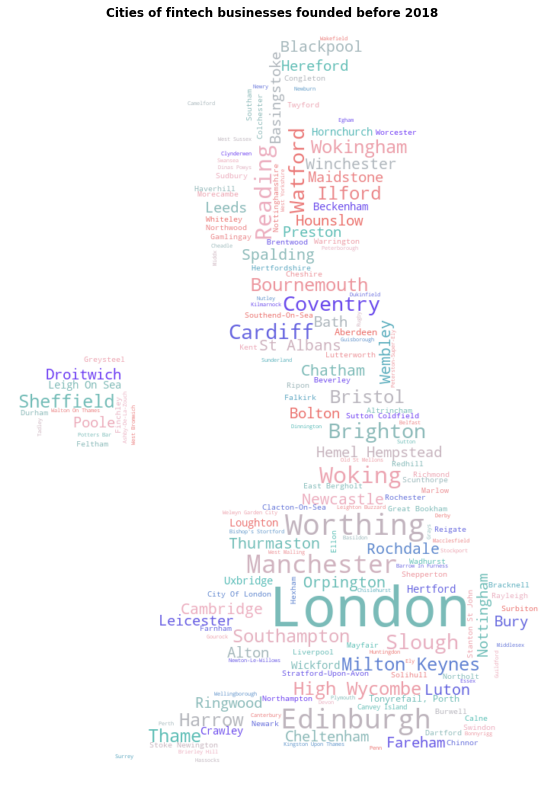

In [579]:
get_word_cloud(frequency_of_old_fintech)